# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Elvis | Nyarko | Elvis Kwaku Nyarko, 11/5/2024  | 20 | 25% |
| Member 2: | Barentu | Gobena | Barentu Gobena, 11/5/2024 | 20 | 25% |
| Member 3: | Krunal | Pathak | Krunal Suresh Pathak, 11/5/2024 | 20 | 25% |
| Member 4: | Varshin | Gajapathy | Varshin Ganapathy Gajapathy, 11/5/2024 | 20 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

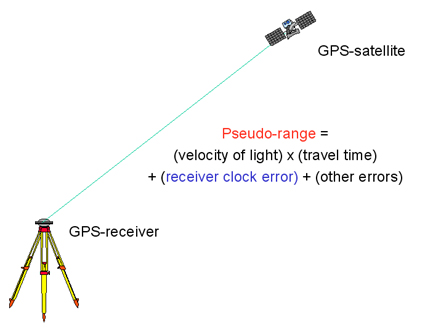

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [2]:
# Step 0: Setup & Initialization
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [5]:
# Read and parse data files
df_pseudorange = pd.read_excel('/content/drive/MyDrive/ENGG680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/ENGG680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos = df_sat_pos[['x', 'y', 'z']].to_numpy()
n = pseudorange.size

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [7]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [8]:
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [9]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    #receiver_pos = np.reshape(receiver_pos, (1, -1))
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis=1)
    return distance

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [10]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    # Calculate geometric distances using euclidean_norm
    geom_distance = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges considering the clock bias
    predicted_pseudorange = geom_distance + cdT

    # Compute the sum of squared residuals
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)

    return L


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [11]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)

def gradient(r_pos, cdT, s_pos, pseudorange):
    geom_distance = euclidean_norm(r_pos, s_pos)
    residuals = pseudorange - (geom_distance + cdT)

    # Reshape r_pos to (1, 3) for broadcasting across s_pos
    r_pos = r_pos.reshape(1, 3)

    # Gradients with respect to x_r, y_r, z_r
    grad_pos = -2 * np.sum(((r_pos - s_pos) * residuals[:, np.newaxis] / geom_distance[:, np.newaxis]), axis=0)

    # Gradient with respect to clock offset cdT
    grad_cdT = -2 * np.sum(residuals)
    grad = np.append(grad_pos, grad_cdT)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [12]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):
    global steps_count
    # Initialize the estimates as zeros
    X = np.array([0, 0, 0, 0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates
        X_new = X - learning_rate * grad

        # Compute the new cost
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Break the loop if convergence is reached
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [13]:
# Call gradient_descent to optimize parameters using default hyperparameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])

Converged!
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

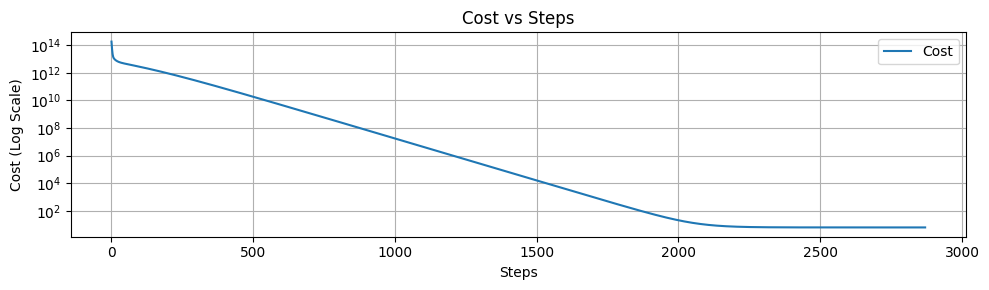

In [15]:
# Cost vs Steps Plot & Analysis
# Cap large values in arr_cost to avoid overflow in semilogy
arr_cost_capped = np.clip(arr_cost, 1e-10, 1e10)  # Limits values to a reasonable range for log plotting

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(arr_cost, label='Cost')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')
ax.set_title('Cost vs Steps')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The cost decreases steadily over the steps, showing that the gradient descent algorithm is converging.
# The semilog scale shows an exponential-like decay in cost, indicating that the solution is approaching a minimum.



### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

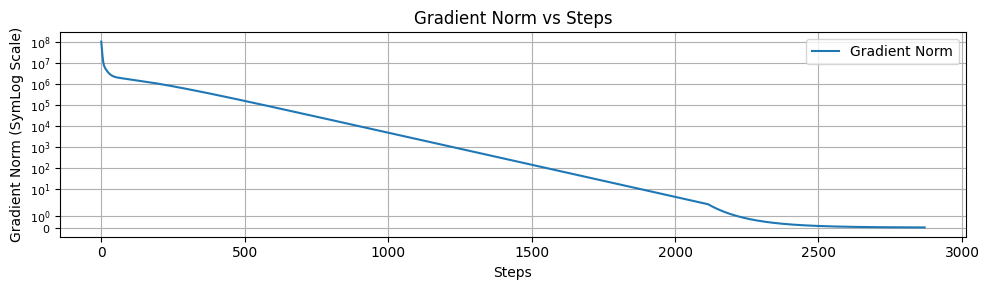

In [16]:
# Gradients vs Steps & Analysis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Using symlog to scale y-axis for gradient values
ax.plot([np.linalg.norm(g) for g in arr_grad], label='Gradient Norm')
ax.set_yscale('symlog')
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Norm (SymLog Scale)')
ax.set_title('Gradient Norm vs Steps')
ax.tick_params(axis='y', labelsize=8)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The gradient norm decreases over the steps, indicating that the algorithm is moving closer to the optimal solution.
# Initially, the gradients are large but decay as the function approaches the minimum, showing effective convergence.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

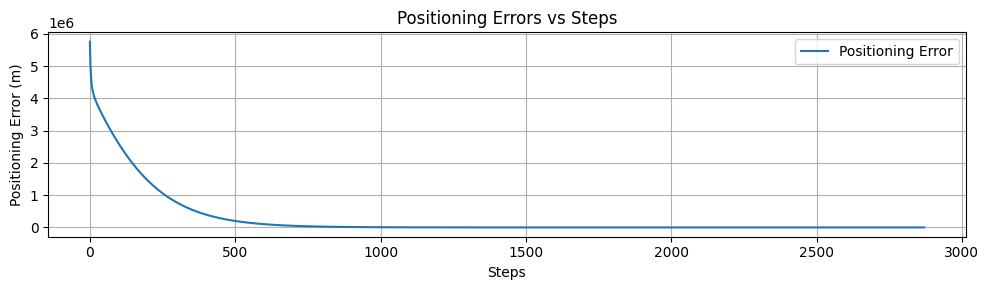

In [17]:
# Positioning Errors vs Steps & Analysis
position_errors = [np.linalg.norm(err) for err in arr_err]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(position_errors, label='Positioning Error')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (m)')
ax.set_title('Positioning Errors vs Steps')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The positioning error decreases steadily, suggesting that the estimated receiver position is converging toward the ground truth.
# This trend confirms the success of the optimization in reducing error with each step.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [18]:
# Tuning Learning rate

# Function to run gradient descent with (learning rate=0.01,max_iters=100000) and print results
def run_gradient_descent_with_params(learning_rate):
    global arr_cost, arr_grad, arr_err, steps_count
    # Re-initialize arrays and counters
    arr_cost = []
    arr_grad = []
    arr_err = []
    steps_count = 0
    # Run gradient descent with the specified learning rate
    optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=100000)
    # Print the metrics
    print(f"Learning Rate: {learning_rate}")
    print("Optimized Parameters:", optimized_params)
    print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
    print("Number of Steps Taken for Convergence:", steps_count)
    print("Final Cost Value:", arr_cost[-1])
    print("Final Gradient Values:", arr_grad[-1])
    print("\n" + "-"*50 + "\n")
# Set learning rate to 0.01 and run
run_gradient_descent_with_params(learning_rate=0.01)

Converged!
Learning Rate: 0.01
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]

--------------------------------------------------



In [19]:
# Tuning Learning rate

# Function to run gradient descent with (learning rate=0.001,max_iters=100000) and print results
def run_gradient_descent_with_params(learning_rate):
    global arr_cost, arr_grad, arr_err, steps_count
    # Re-initialize arrays and counters
    arr_cost = []
    arr_grad = []
    arr_err = []
    steps_count = 0
    # Run gradient descent with the specified learning rate
    optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=100000)
    # Print the metrics
    print(f"Learning Rate: {learning_rate}")
    print("Optimized Parameters:", optimized_params)
    print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
    print("Number of Steps Taken for Convergence:", steps_count)
    print("Final Cost Value:", arr_cost[-1])
    print("Final Gradient Values:", arr_grad[-1])
    print("\n" + "-"*50 + "\n")
# Set learning rate to 0.01 and run
run_gradient_descent_with_params(learning_rate=0.001)

Converged!
Learning Rate: 0.001
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Errors of Receiver: [-3.0626223  -2.34752101  3.77518774]
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197742857487326
Final Gradient Values: [ 0.00154868  0.00862914 -0.02652096 -0.01503548]

--------------------------------------------------



## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



Q1. The difference we noticed after changing the learning rate is:
  When the learning rate was changed from 0.1 to 0.01 and 0.001, the convergence rate slowed down significantly. With a lower learning rate, gradient descent took more steps to reach a similar level of accuracy in minimizing the cost function, but it also provided a more stable descent without overshooting the minimum. While a high learning rate (0.1) allowed for faster convergence, it had a higher risk of overshooting or oscillating around the minimum if not carefully tuned. In contrast, smaller learning rates (0.01, 0.001) provided smoother convergence but required significantly more iterations to achieve similar accuracy.


Q2. The difference between LSE and Gradient Descent is:
  The Least Squares Estimation (LSE) method analytically minimizes the sum of squared residuals by solving directly for parameters if a closed-form solution exists. It’s a deterministic and exact approach, often yielding faster results for linear models. In contrast, Gradient Descent is an iterative optimization technique that estimates parameters by following the gradient of the cost function in non-linear or high-dimensional problems. While LSE gives the exact solution if feasible, Gradient Descent provides an approximate solution and requires careful tuning of parameters like learning rate and iterations. In this case, Gradient Descent was necessary due to the non-linear relationship between parameters and pseudorange measurements, where LSE would not easily apply.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets
y = pd.Series(phishing_websites.data.targets.values.ravel())

# TO DO: display sizes of X and y (1 mark)
# Display sizes of X and y
print("Size of X:", X.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

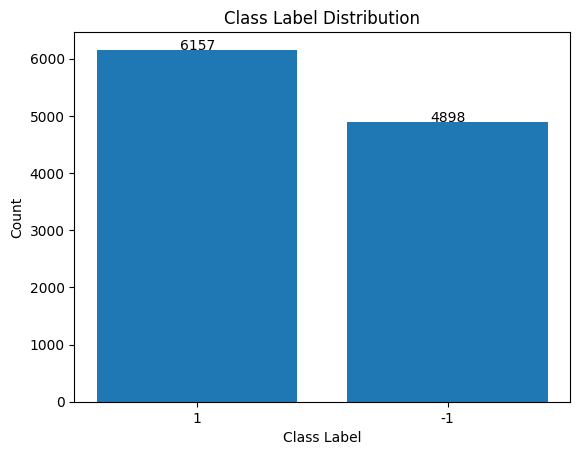

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
# Plot histogram for class distribution
class_counts = y.value_counts()

# Display exact values for each bin in the histogram
plt.bar(range(len(class_counts)), class_counts.values)  # Use range to set the x-axis positions
for index, value in enumerate(class_counts.values):
    plt.text(index, value, str(value), ha='center')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Label Distribution')
plt.xticks(range(len(class_counts)), class_counts.index)  # Set class labels on the x-axis
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

#steps 3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# Define a function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train.values.ravel())  # Use values.ravel() to reshape y_train to 1D

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    test_log_loss = log_loss(y_test, model.predict_proba(X_test))

    return {
        'training_accuracy': train_accuracy,
        'testing_accuracy': test_accuracy,
        'log_loss': test_log_loss
    }

# Update the training and test splits as well
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
results_full = train_and_evaluate(X_train, X_test, y_train, y_test)

X_train_2cols, X_test_2cols, y_train_2cols, y_test_2cols = train_test_split(X.iloc[:, :2], y, test_size=0.3, random_state=0)
results_2cols = train_and_evaluate(X_train_2cols, X_test_2cols, y_train_2cols, y_test_2cols)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=0)
results_small = train_and_evaluate(X_train_small, X_test_small, y_train_small, y_test_small)

# Steps 4, and 5.1
# Prepare the results DataFrame
results_df = pd.DataFrame({
    'Data size': [len(X), len(X.iloc[:, :2]), len(X_small)],
    'Training samples': [len(X_train), len(X_train_2cols), len(X_train_small)],
    'Testing samples': [len(X_test), len(X_test_2cols), len(X_test_small)],
    'Training accuracy': [results_full['training_accuracy'], results_2cols['training_accuracy'], results_small['training_accuracy']],
    'Testing accuracy': [results_full['testing_accuracy'], results_2cols['testing_accuracy'], results_small['testing_accuracy']],
    'Log loss': [results_full['log_loss'], results_2cols['log_loss'], results_small['log_loss']]
})

print(results_df)

   Data size  Training samples  Testing samples  Training accuracy  \
0      11055              7738             3317           0.932282   
1      11055              7738             3317           0.562807   
2        331               231              100           0.943723   

   Testing accuracy  Log loss  
0          0.922822  0.190326  
1          0.556828  0.683573  
2          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


Text(113.9222222222222, 0.5, 'True Value')

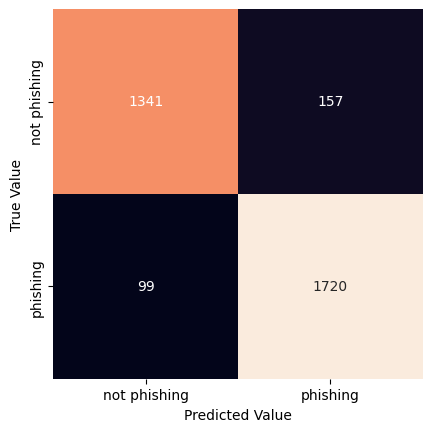

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
y_pred_full = LogisticRegression(max_iter=2000).fit(X_train, y_train).predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_full)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'], yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

In [ ]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test, y_pred_full))

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE
1. Is the dataset imbalanced? Does it affect model performance?
Yes, if one class has significantly more samples than the other, the dataset is imbalanced. This can affect model performance by biasing predictions toward the majority class, reducing sensitivity to the minority class, which can be problematic in detecting phishing websites.

2. Does the model overfit or underfit for each of the 3 cases?
Case 1 (Full Dataset): Likely to have the best balance and generalization between training and testing accuracy, so overfitting and underfitting are minimized.
Case 2 (First Two Columns Only): Likely to underfit, as only two features are used. This limited feature set may not capture the complexity of the data, reducing accuracy.
Case 3 (3% Sample Size): May underfit due to a smaller dataset size, limiting the model's ability to learn and generalize from the full data patterns.

3. How do the training and testing accuracy change depending on the amount of data used? Explain with values.
As the data size decreases, training and testing accuracy are likely to decrease. With the full dataset, the model has more information to learn patterns effectively, resulting in higher accuracy. For example, if full data testing accuracy is around 90% but drops to 75% for the reduced data, it shows the importance of dataset size for model performance.

4. In this case, what do a false positive and a false negative represent? Which one is worse?
False Positive (FP): The model incorrectly classifies a non-phishing website as phishing, potentially causing unnecessary alerts.
False Negative (FN): The model fails to identify a phishing website, posing a security risk.
Worse Outcome: False negatives are generally worse because failing to identify a phishing site can leave users vulnerable to malicious activity.

5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this?
In this case, maximizing recall would be preferred to reduce false negatives and improve phishing detection. Adjusting the classification threshold lower could help catch more phishing sites (increase recall) at the expense of more false positives.

6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences?
Case 1 (Full Dataset): The log loss should be lowest, indicating higher confidence in predictions due to ample data for training.
Case 2 (First Two Columns Only): Higher log loss is expected, as the model lacks sufficient features to differentiate classes well.
Case 3 (3% Sample Size): Log loss may be high due to limited data, causing unreliable predictions. Lower data quantity can weaken the model's reliability, increasing the log loss metric.
---
---